<span style = "font-family: Arial; font-weight:bold;font-size:2.5em;color:blue;">Scale Model Cars Database Analysis (SQL)

Customers and Products Analysis Using SQL

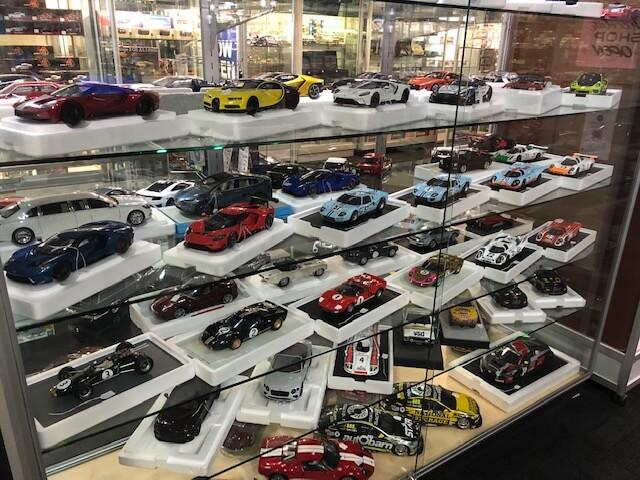
*Source*: [Diecast Secrets](https://www.carmodels.com.au/blogs/news/16248-diecast-secrets-starting-a-model-car-collection)

<span style = "font-family: Arial; font-weight:bold;font-size:2.2em;color:black;"> Introduction

The Vehicle Distributors is a fictitious global wholesale distributor specializing in die-cast vehicle models, serving a diverse customer base across more than 15 countries. Our team has been entrusted with a significant dataset analysis project, aimed at assisting the company in making strategic decisions concerning prospective expansion efforts. 

The primary goal of this undertaking is to comprehensively investigate the provided dataset and furnish well-informed responses, driven by data, to the questions posed by our client.

The provided dataset, along with its corresponding schema, can be found [here]().

The scale model cars database contains eight tables:

1. **Customers**: customer data
2. **Employees**: all employee information
3. **Offices**: sales office information
4. **Orders**: customers' sales orders
5. **OrderDetails**: sales order line for each sales order
6. **Payments**: customers' payment records
7. **Products**: a list of scale model cars
8. **ProductLines**: a list of product line categories


The scale model cars database schema is as follows.

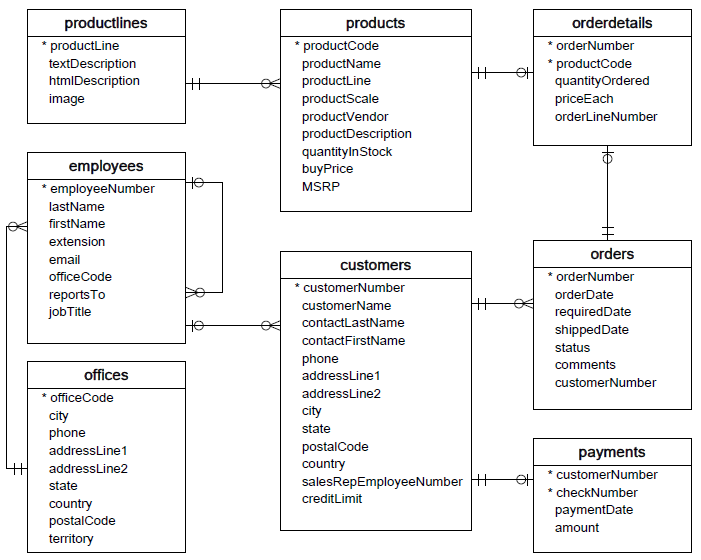

---

<span style = "font-family: Arial; font-weight:bold;font-size:2.2em;color:black;"> Objectives

The primary objective of this project is to conduct an in-depth analysis of data from a sales records database, with the intent of extracting meaningful insights that can be employed to enhance decision-making processes. The power of data analysis in the realm of sales is well-established, as it enables the derivation of essential Key Performance Indicators (KPIs), thereby fostering more informed and streamlined decision-making practices.

Utilizing data analysis offers the potential for significant savings in terms of time, resources, and financial investments. Sales data analysis encompasses a wide array of elements, including sales performance, production, customer satisfaction, and workforce efficiency, presenting a diverse set of challenges that must be addressed. To realize the overarching objectives of this project, we will delve into the following inquiries to reveal practical and actionable insights


1. <a href="#Question_1">Which products need more or less inventory?</a>
2. <a href="#Question_2">How can we tailor marketing to customer behaviors?</a>
3. <a href="#Question_3">What is the budget for acquiring new customers?</a>
4. <a href="#Question_4">Which countries should marketing prioritize for best returns?</a>


---

# Importing Libraries

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

---

# Databse connection

In [2]:
%%capture
%load_ext sql
%sql sqlite:///stores.db

---

# Exploring database

## Structure

In [3]:
%%sql
SELECT '' AS Table_Names,'' AS Number_of_Attributes,'' AS Number_of_Rows
UNION ALL
SELECT 'Customer',13,(SELECT COUNT(*)
                        FROM customers)
UNION ALL
SELECT 'Products',9,(SELECT COUNT(*)
                        FROM products)
UNION ALL
SELECT 'ProductLines',4,(SELECT COUNT(*)
                        FROM productlines)
UNION ALL
SELECT 'Orders',7,(SELECT COUNT(*)
                        FROM orders)
UNION ALL
SELECT 'OrderDetails',5,(SELECT COUNT(*)
                        FROM orderdetails)
UNION ALL
SELECT 'Payments',4,(SELECT COUNT(*)
                        FROM payments)
UNION ALL
SELECT 'Employees',8,(SELECT COUNT(*)
                        FROM employees)
UNION ALL
SELECT 'Offices',9,(SELECT COUNT(*)
                        FROM offices)

 * sqlite:///stores.db
Done.


Table_Names,Number_of_Attributes,Number_of_Rows
,,
Customer,13,122
Products,9,110
ProductLines,4,7
Orders,7,326
OrderDetails,5,2996
Payments,4,273
Employees,8,23
Offices,9,7


----

**Using Python to create a generic Structure Summary**

In [4]:
# Connect to the SQLite database
connection = sqlite3.connect('stores.db')

# Step 1: Get the names of all tables
table_names = connection.execute(
    "SELECT name FROM sqlite_master WHERE type='table';").fetchall()
table_names = [table[0] for table in table_names]

# Step 2: Get the number of attributes for each table
table_attributes = {}
for table_name in table_names:
    attributes_count = connection.execute(
        f"PRAGMA table_info({table_name});").fetchall()
    table_attributes[table_name] = len(attributes_count)

# Step 3: Get the number of rows for each table
table_rows = {}
for table_name in table_names:
    rows_count = connection.execute(
        f"SELECT count(*) FROM {table_name};").fetchone()[0]
    table_rows[table_name] = rows_count

# Create a DataFrame
data = {'Table Name': table_names, 'Attributes Count': [
    table_attributes[table] for table in table_names], 'Rows Count': [table_rows[table] for table in table_names]}
df = pd.DataFrame(data)

# Display the DataFrame
df

,Table Name,Attributes Count,Rows Count
0,customers,13,122
1,employees,8,23
2,offices,9,7
3,orderdetails,5,2996
4,orders,7,326
5,payments,4,273
6,productlines,4,7
7,products,9,110


There are **110** products across **7** product lines 

---

**Using Python to get missing value summary**

In [5]:
cursor = connection.cursor()

# Get a list of all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = [row[0] for row in cursor.fetchall()]

# Create an empty summary DataFrame
summary_data = []

# Iterate through each table and count missing values in each column
for table_name in table_names:
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = [row[1] for row in cursor.fetchall()]
    
    for column in columns:
        cursor.execute(f"SELECT COUNT(*) FROM {table_name} WHERE {column} IS NULL;")
        missing_count = cursor.fetchone()[0]
        if missing_count > 0:
            summary_data.append([table_name, column, missing_count])

# Create a Pandas DataFrame
summary_df = pd.DataFrame(summary_data, columns=['Table Name', 'Column Name', 'Missing Count'])

# Display the summary in table format
summary_df

,Table Name,Column Name,Missing Count
0,customers,addressLine2,100
1,customers,state,73
2,customers,postalCode,7
3,customers,salesRepEmployeeNumber,22
4,employees,reportsTo,1
5,offices,addressLine2,2
6,offices,state,3
7,orders,shippedDate,14
8,orders,comments,246
9,productlines,htmlDescription,7


---

# Database exploration

**Lets see the first 5 rows in the `products` table**

In [6]:
%%sql
SELECT *
  FROM products LIMIT 5;

 * sqlite:///stores.db
Done.


productCode,productName,productLine,productScale,productVendor,productDescription,quantityInStock,buyPrice,MSRP
S10_1678,1969 Harley Davidson Ultimate Chopper,Motorcycles,1:10,Min Lin Diecast,"This replica features working kickstand, front suspension, gear-shift lever, footbrake lever, drive chain, wheels and steering. All parts are particularly delicate due to their precise scale and require special care and attention.",7933,48.81,95.7
S10_1949,1952 Alpine Renault 1300,Classic Cars,1:10,Classic Metal Creations,Turnable front wheels; steering function; detailed interior; detailed engine; opening hood; opening trunk; opening doors; and detailed chassis.,7305,98.58,214.3
S10_2016,1996 Moto Guzzi 1100i,Motorcycles,1:10,Highway 66 Mini Classics,"Official Moto Guzzi logos and insignias, saddle bags located on side of motorcycle, detailed engine, working steering, working suspension, two leather seats, luggage rack, dual exhaust pipes, small saddle bag located on handle bars, two-tone paint with chrome accents, superior die-cast detail , rotating wheels , working kick stand, diecast metal with plastic parts and baked enamel finish.",6625,68.99,118.94
S10_4698,2003 Harley-Davidson Eagle Drag Bike,Motorcycles,1:10,Red Start Diecast,"Model features, official Harley Davidson logos and insignias, detachable rear wheelie bar, heavy diecast metal with resin parts, authentic multi-color tampo-printed graphics, separate engine drive belts, free-turning front fork, rotating tires and rear racing slick, certificate of authenticity, detailed engine, display stand\r\n, precision diecast replica, baked enamel finish, 1:10 scale model, removable fender, seat and tank cover piece for displaying the superior detail of the v-twin engine",5582,91.02,193.66
S10_4757,1972 Alfa Romeo GTA,Classic Cars,1:10,Motor City Art Classics,Features include: Turnable front wheels; steering function; detailed interior; detailed engine; opening hood; opening trunk; opening doors; and detailed chassis.,3252,85.68,136


**Lets get a view of the product lines**

In [7]:
%%sql
SELECT DISTINCT productLine
  FROM productlines

 * sqlite:///stores.db
Done.


productLine
Classic Cars
Motorcycles
Planes
Ships
Trains
Trucks and Buses
Vintage Cars


**Now lets get a view of the `customers` table**

In [8]:
%%sql
SELECT *
  FROM customers LIMIT 5;

 * sqlite:///stores.db
Done.


customerNumber,customerName,contactLastName,contactFirstName,phone,addressLine1,addressLine2,city,state,postalCode,country,salesRepEmployeeNumber,creditLimit
103,Atelier graphique,Schmitt,Carine,40.32.2555,"54, rue Royale",None,Nantes,None,44000,France,1370,21000
112,Signal Gift Stores,King,Jean,7025551838,8489 Strong St.,None,Las Vegas,NV,83030,USA,1166,71800
114,"Australian Collectors, Co.",Ferguson,Peter,03 9520 4555,636 St Kilda Road,Level 3,Melbourne,Victoria,3004,Australia,1611,117300
119,La Rochelle Gifts,Labrune,Janine,40.67.8555,"67, rue des Cinquante Otages",None,Nantes,None,44000,France,1370,118200
121,Baane Mini Imports,Bergulfsen,Jonas,07-98 9555,Erling Skakkes gate 78,None,Stavern,None,4110,Norway,1504,81700


**Lets get the top 10 customer count by country**

In [9]:
%%sql
SELECT 
    country,
    COUNT(customerNumber) as customer_count,
    ROUND(COUNT(country) * 100.0 / SUM(COUNT(country)) OVER(), 1) AS 'percentage_%'
  FROM customers
 GROUP BY country

ORDER BY customer_count DESC
LIMIT 10;

 * sqlite:///stores.db
Done.


country,customer_count,percentage_%
USA,36,29.5
Germany,13,10.7
France,12,9.8
Spain,7,5.7
Australia,5,4.1
UK,5,4.1
Italy,4,3.3
New Zealand,4,3.3
Canada,3,2.5
Finland,3,2.5


---

**Now lets get a view of the `orders` table**

In [10]:
%%sql
SELECT *
  FROM orders LIMIT 5;

 * sqlite:///stores.db
Done.


orderNumber,orderDate,requiredDate,shippedDate,status,comments,customerNumber
10100,2003-01-06,2003-01-13,2003-01-10,Shipped,None,363
10101,2003-01-09,2003-01-18,2003-01-11,Shipped,Check on availability.,128
10102,2003-01-10,2003-01-18,2003-01-14,Shipped,None,181
10103,2003-01-29,2003-02-07,2003-02-02,Shipped,None,121
10104,2003-01-31,2003-02-09,2003-02-01,Shipped,None,141


**Lets get a view and count of the order status**

In [11]:
%%sql
SELECT 
  status AS order_status,
  COUNT(status) AS orders_num,
  ROUND(COUNT(status) * 100.0 / SUM(COUNT(status)) OVER(), 1) AS 'percentage_%'
FROM orders 
GROUP BY status
ORDER BY orders_num DESC

 * sqlite:///stores.db
Done.


order_status,orders_num,percentage_%
Shipped,303,92.9
Cancelled,6,1.8
In Process,6,1.8
On Hold,4,1.2
Resolved,4,1.2
Disputed,3,0.9


---

# Database Analysis

<a id="Question_1"></a>
## Which products need more or less inventory?

The goal is to optimize inventory levels by examining inventory reports to pinpoint in-demand products that are running low and analyze which products are selling well. This will help prevent popular items from going out of stock, improving the customer experience.

Top priority for restocking will be given to high-performing products that are nearing out of stock status. Promptly replenishing these successful, sought-after products will help maintain sufficient inventory to meet customer demand. Focusing restocking efforts on the most popular and fastest-selling items aligns with the objectives of keeping adequate stock of products customers want and providing a positive shopping experience.

**The top 10 low stock for each product**

In [12]:
%%sql
SELECT p.productCode,
       p.productName,
       sum(o.quantityOrdered)/p.quantityInStock as low_stock
  FROM products p 
  JOIN orderdetails o 
    ON p.productCode = o.productCode 
 GROUP BY p.productCode 
 ORDER BY low_stock DESC 
 LIMIT 10;

 * sqlite:///stores.db
Done.


productCode,productName,low_stock
S24_2000,1960 BSA Gold Star DBD34,67
S12_1099,1968 Ford Mustang,13
S32_4289,1928 Ford Phaeton Deluxe,7
S32_1374,1997 BMW F650 ST,5
S72_3212,Pont Yacht,2
S700_3167,F/A 18 Hornet 1/72,1
S700_1938,The Mayflower,1
S50_4713,2002 Yamaha YZR M1,1
S32_3522,1996 Peterbilt 379 Stake Bed with Outrigger,1
S18_2795,1928 Mercedes-Benz SSK,1


**The top 10 product performance for each product**

In [13]:
%%sql
SELECT 
    p.productCode,
    p.productName, 
    round(sum(o.quantityOrdered*o.priceEach),2) as product_performance
 FROM orderdetails o 
 JOIN products p 
   ON p.productCode = o.productCode 
GROUP BY p.productCode 
ORDER BY product_performance DESC 
LIMIT 10;

 * sqlite:///stores.db
Done.


productCode,productName,product_performance
S18_3232,1992 Ferrari 360 Spider red,276839.98
S12_1108,2001 Ferrari Enzo,190755.86
S10_1949,1952 Alpine Renault 1300,190017.96
S10_4698,2003 Harley-Davidson Eagle Drag Bike,170686.0
S12_1099,1968 Ford Mustang,161531.48
S12_3891,1969 Ford Falcon,152543.02
S18_1662,1980s Black Hawk Helicopter,144959.91
S18_2238,1998 Chrysler Plymouth Prowler,142530.63
S18_1749,1917 Grand Touring Sedan,140535.6
S12_2823,2002 Suzuki XREO,135767.03


**Priority products for restocking**

In [14]:
%%sql
WITH
table1 AS(
    SELECT
        p.productCode
    FROM (SELECT
              p.productCode,
              p.productName,
              sum(o.quantityOrdered) / p.quantityInStock as low_stock
          FROM products p
          JOIN orderdetails o 
            ON p.productCode=o.productCode
         GROUP BY p.productCode
         ORDER BY low_stock DESC
         ) AS p
),
table2 AS(
    SELECT
        p.productCode
    FROM (SELECT
              p.productCode, 
              p.productLine,
              p.productName,
              round(sum(o.quantityOrdered * o.priceEach), 2) as product_performance
           FROM orderdetails o
           JOIN products p 
             ON p.productCode=o.productCode
          GROUP BY p.productCode
          ORDER BY product_performance DESC
          LIMIT 10
         ) AS p
)
SELECT
    p.productCode, 
    p.productName, 
    p.productLine
 FROM products p
WHERE p.productCode IN table1 AND p.productCode IN table2

 * sqlite:///stores.db
Done.


productCode,productName,productLine
S10_1949,1952 Alpine Renault 1300,Classic Cars
S10_4698,2003 Harley-Davidson Eagle Drag Bike,Motorcycles
S12_1099,1968 Ford Mustang,Classic Cars
S12_1108,2001 Ferrari Enzo,Classic Cars
S12_2823,2002 Suzuki XREO,Motorcycles
S12_3891,1969 Ford Falcon,Classic Cars
S18_1662,1980s Black Hawk Helicopter,Planes
S18_1749,1917 Grand Touring Sedan,Vintage Cars
S18_2238,1998 Chrysler Plymouth Prowler,Classic Cars
S18_3232,1992 Ferrari 360 Spider red,Classic Cars


In [15]:
# Connect to the SQLite database
connection = sqlite3.connect('stores.db')

priority_prods_query ="""WITH
table1 AS(
    SELECT
        p.productCode
    FROM (SELECT
              p.productCode,
              p.productName,
              sum(o.quantityOrdered) / p.quantityInStock as low_stock
          FROM products p
          JOIN orderdetails o 
            ON p.productCode=o.productCode
         GROUP BY p.productCode
         ORDER BY low_stock DESC
         ) AS p
),
table2 AS(
    SELECT
        p.productCode
    FROM (SELECT
              p.productCode, 
              p.productLine,
              p.productName,
              round(sum(o.quantityOrdered * o.priceEach), 2) as product_performance
           FROM orderdetails o
           JOIN products p 
             ON p.productCode=o.productCode
          GROUP BY p.productCode
          ORDER BY product_performance DESC
          LIMIT 10
         ) AS p
)
SELECT
    p.productCode, 
    p.productName, 
    p.productLine
 FROM products p
WHERE p.productCode IN table1 AND p.productCode IN table2"""

priority_prods = pd.read_sql_query(priority_prods_query, connection)


We shall use bar chart to represent the categorical variables.

In [16]:
def bar_chart(data):
    """
    This function below generates a `bar chart` showing
    the `distribution of the categorical varible input`.
    * The function also `generates an image file` of the plot.
    * The function takes the Pandas series as the input.
    * It `computes the frequency of each unique element` and 
      displays the distribution of the elements to in horizontal bars.
    * The `percentage of each bar` is also calculated and placed to 
      the right end of each bar.
    * `sns.despine()` - removes the upper and right border of the chart
    * For each horizontal bar the width is calculated as a percentage of
      the entire quanta of datapoints.
    * The percentage is annotated to the each bar by plotting the cardinal locations.

    """
    
    # Create a horizontal count plot while sorting variables in descending order
    g=sns.countplot(y=data)
    # Remove the top and right spines from plot
    sns.despine()
    # length of the column
    col_length = len(data) 
    for p in g.patches:
        # percentage of each class of the category
        percentage = '{:.1f}%'.format(100 * p.get_width()/col_length)
        # width of the plot
        x = p.get_x() + p.get_width() + 0.02
        # height of the plot
        y = p.get_y() + p.get_height()/2
        # annotate the percentage
        g.annotate(percentage, (x, y), size = 12) 
        plt.title("Distribution of {}".format(data.name),loc="center",fontsize = 22)
    plt.show()
    # Line separator

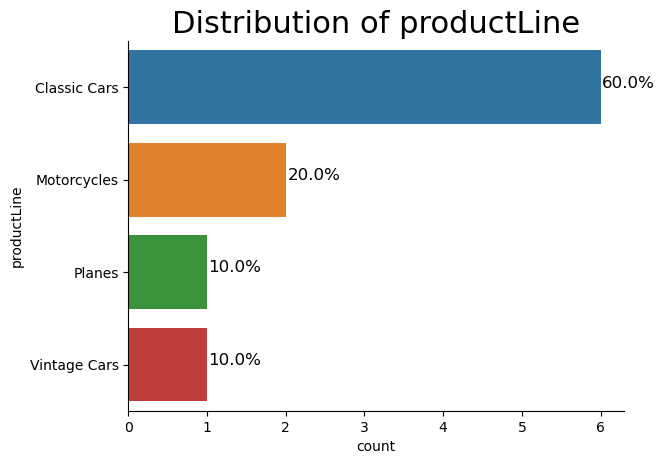

In [17]:
bar_chart(priority_prods.productLine)

Classic cars and motorcycles are in high demand and top priority for restocking inventory. However, vintage cars and planes have seen steady, even interest over time.

---

**Dead stock**

Deadstock are products unsold for a long time. They can become a financial burden by occupying storage space and risking damage. Deadstock is challenging to deal with as it may continue to go unsold, incurring more costs.

In [18]:
%%sql
SELECT
    productCode, 
    productName,
    quantityInStock , 
    buyPrice
FROM products
WHERE productCode NOT IN (SELECT productCode FROM orderdetails);

 * sqlite:///stores.db
Done.


productCode,productName,quantityInStock,buyPrice
S18_3233,1985 Toyota Supra,7733,57.01


A potential strategy for slow-moving deadstock is price reductions to increase appeal and accelerate sales. Though counterintuitive, lower prices could save more money long-term than holding deadstock and prolonging costs.

---

<a id="Question_2"></a>
## How can we tailor marketing to customer behaviors?

To address the question about customer information, we will segment customers into VIPs (Very Important Persons) and less engaged users. This categorization enables tailored strategies that meet the specific needs of each customer group.

**Lets get the profit by customer**

In [19]:
%%sql
SELECT 
    o.customerNumber, 
    round(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)),2) AS profit
 FROM orders o
 JOIN orderdetails od 
   ON od.orderNumber = o.orderNumber
 JOIN products p 
   ON p.productCode = od.productCode
GROUP BY o.customerNumber
ORDER BY profit DESC;

 * sqlite:///stores.db
Done.


customerNumber,profit
141,326519.66
124,236769.39
151,72370.09
114,70311.07
119,60875.3
148,60477.38
187,60095.86
323,60013.99
131,58669.1
450,55931.37


**Top 5 VIP customers**

In [20]:
%%sql
WITH performance AS (
    SELECT o.customerNumber, 
    round(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)),2) AS profit
    FROM orders o
    JOIN orderdetails od 
      ON od.orderNumber = o.orderNumber
    JOIN products p 
      ON p.productCode = od.productCode
   GROUP BY o.customerNumber
   ORDER BY profit DESC
)

SELECT 
    c.contactFirstName ||" "||c.contactLastName as name,
    c.city,
    c.country, 
    profit
FROM customers c 
JOIN performance 
  ON performance.customerNumber = c.customerNumber 
LIMIT 5;

 * sqlite:///stores.db
Done.


name,city,country,profit
Diego Freyre,Madrid,Spain,326519.66
Susan Nelson,San Rafael,USA,236769.39
Jeff Young,NYC,USA,72370.09
Peter Ferguson,Melbourne,Australia,70311.07
Janine Labrune,Nantes,France,60875.3


**The top five least-engaged customers**

In [21]:
%%sql
WITH performance AS (
    SELECT o.customerNumber, 
           round(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)),2) AS profit
      FROM orders o
      JOIN orderdetails od 
        ON od.orderNumber = o.orderNumber
      JOIN products p 
        ON p.productCode = od.productCode
     GROUP BY o.customerNumber
     ORDER BY profit
)

SELECT 
    c.contactFirstName ||" "||c.contactLastName as name,
    c.city,
    c.country, 
    profit
FROM customers c 
JOIN performance 
  ON performance.customerNumber = c.customerNumber  
LIMIT 5;

 * sqlite:///stores.db
Done.


name,city,country,profit
Mary Young,Glendale,USA,2610.87
Leslie Taylor,Brickhaven,USA,6586.02
Franco Ricotti,Milan,Italy,9532.93
Carine Schmitt,Nantes,France,10063.8
Thomas Smith,London,UK,10868.04


---

<a id="Question_3"></a>
## What is the budget for acquiring new customers?

To determine the budget for acquiring new customers, we need to calculate the Customer Lifetime Value (LTV). LTV shows the average revenue generated per customer over the entire customer relationship. This will indicate how much we can optimally spend on marketing to gain new customers.

**Compute the Customer Lifetime Value**

In [22]:
%%sql
WITH  performance AS (
    SELECT 
        o.customerNumber, 
        round(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)),2) AS profit
      FROM orders o
      JOIN orderdetails od 
        ON od.orderNumber = o.orderNumber
      JOIN products p 
        ON p.productCode = od.productCode
     GROUP BY o.customerNumber
     ORDER BY profit
)

SELECT round(avg(profit),2) as Customer_lifetime_value
  FROM performance;

 * sqlite:///stores.db
Done.


Customer_lifetime_value
39039.59


The Lifetime Value (LTV) metric shows the total profitability of an average customer with our store. It allows us to forecast potential profits, like estimating we could earn \\$390,395 ($39,039.59 X 10) by acquiring 10 new customers next month. Knowing the LTV helps us set appropriate budgets for gaining new customers, as we can predict the long-term value of acquisitions.

----

<a id="Question_4"></a>
## Which countries should marketing prioritize for best returns?

Since marketing has costs, it's important to focus on markets where our strategy will be most profitable. Targeting the highest potential markets will help ensure our marketing drives the best return on investment and maximizes profits.

In [23]:
%%sql
SELECT 
    c.country, 
    round(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)), 2) AS profit
 FROM orders o
 JOIN orderdetails od 
   ON od.orderNumber = o.orderNumber
 JOIN products p 
   ON p.productCode = od.productCode 
 JOIN customers c 
   ON o.customerNumber = c.customerNumber  
GROUP BY c.country 
ORDER BY profit DESC
LIMIT 5;

 * sqlite:///stores.db
Done.


country,profit
USA,1308815.59
Spain,440004.54
France,413016.12
Australia,222207.18
New Zealand,189506.58


The analysis shows we should focus marketing on select markets in North America (USA), Europe (Spain, France), and Oceania (Australia, New Zealand). Concentrating efforts on these high-potential regions will allow efficient resource allocation and let us pursue the most promising opportunities. This targeted approach can improve overall business performance.

----

# Recommendations

After having analysed the data based on the queries put forward by the Vehicle Model Company, the following are the recommendations that we could make based on the insights we have gained.

- To optimize inventory, classic cars and motorcycles should be prioritized for restocking due to high demand, while vintage cars and planes can be managed at a steady pace given even interest over time. For slow-moving deadstock, consider strategic price reductions to increase appeal and accelerate sales. Though counterintuitive, lower prices could reduce losses compared to prolonging costs by holding deadstock. This balanced approach can align inventory to demand and minimize financial burden of deadstock.


- Personalized interactions and recognition of loyal customers can build long-term relationships and repeat business. For VIP customers, we can offer exclusive, tailored events and initiatives to increase satisfaction and loyalty. For less engaged customers, targeted campaigns based on their needs and preferences can reinvigorate interest in our brand.


- We should prioritize marketing in North America (USA), Europe (Spain, France), and Oceania (Australia, New Zealand). Concentrating on these targeted markets can improve efficiency and pursue the most promising opportunities. This focused approach can enhance overall business performance.


----

<a id="Question_3"></a>

<a id="Question_4"></a>

<a id="Question_5"></a>

<a id="Question_6"></a>

<a id="Question_7"></a>

<a id="Question_8"></a>

<a id="Question_9"></a>